In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
DATASET_PATH = './train.csv'
PREPARED_DATASET_PATH = './train_prepared.csv'

In [3]:
df = pd.read_csv(PREPARED_DATASET_PATH, sep=';')

### Используя вновь полученные знания, устраняем недочеты
Удалим столбцы, которые имеют сильную корреляцию между собой - из Rooms, Square, LifeSquare оставим только Square. При обучении моделей эти столбцы из-за сильной корреляции будут бесполезны. Также это позволит избавиться от столбца LifeSquare, в котором было много пропусков, и заполненные нами значения могут быть не репрезентативны. 

Из тех же соображений удалим Social_2.

Удалим столбец Price_1m (цена за квадратный метр), т.к. она содержит целевую переменную. Столбец MeanPriceDistrict удалять не будем, он является Feature encoding для DistrictID. При работе с тестовым датасетом заменим столбец DistrictID соответствующими значениями MeanPriceDistrict. Перед обучением модели столбец DistrictID также удалим.

Удалим LifesquareNan, HealthcareNan - столбца Lifesquare вообще больше нет, а HealthcareNan не имеет видимой корреляции с целевым признаком.

In [4]:
df.drop(['Rooms', 'LifeSquare', 'Social_2', 'Price_1m', 'DistrictId', 'LifeSquareNan', 'Healthcare_1_Nan'], axis=1, inplace=True)
cols = ['MeanPriceDistrict', 'Square', 'LifeSquare_per_Square', 'KitchenSquare', 'Floor', 'HouseFloor',
       'HouseYear', 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2_bin', 'Price']
df = df.reindex(columns=cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9996 entries, 0 to 9995
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   MeanPriceDistrict      9996 non-null   float64
 1   Square                 9996 non-null   float64
 2   LifeSquare_per_Square  9996 non-null   float64
 3   KitchenSquare          9996 non-null   float64
 4   Floor                  9996 non-null   int64  
 5   HouseFloor             9996 non-null   float64
 6   HouseYear              9996 non-null   int64  
 7   Ecology_1              9996 non-null   float64
 8   Ecology_2_bin          9996 non-null   int64  
 9   Ecology_3_bin          9996 non-null   int64  
 10  Social_1               9996 non-null   int64  
 11  Social_3               9996 non-null   int64  
 12  Healthcare_1           9996 non-null   float64
 13  Helthcare_2            9996 non-null   int64  
 14  Shops_1                9996 non-null   int64  
 15  Shop

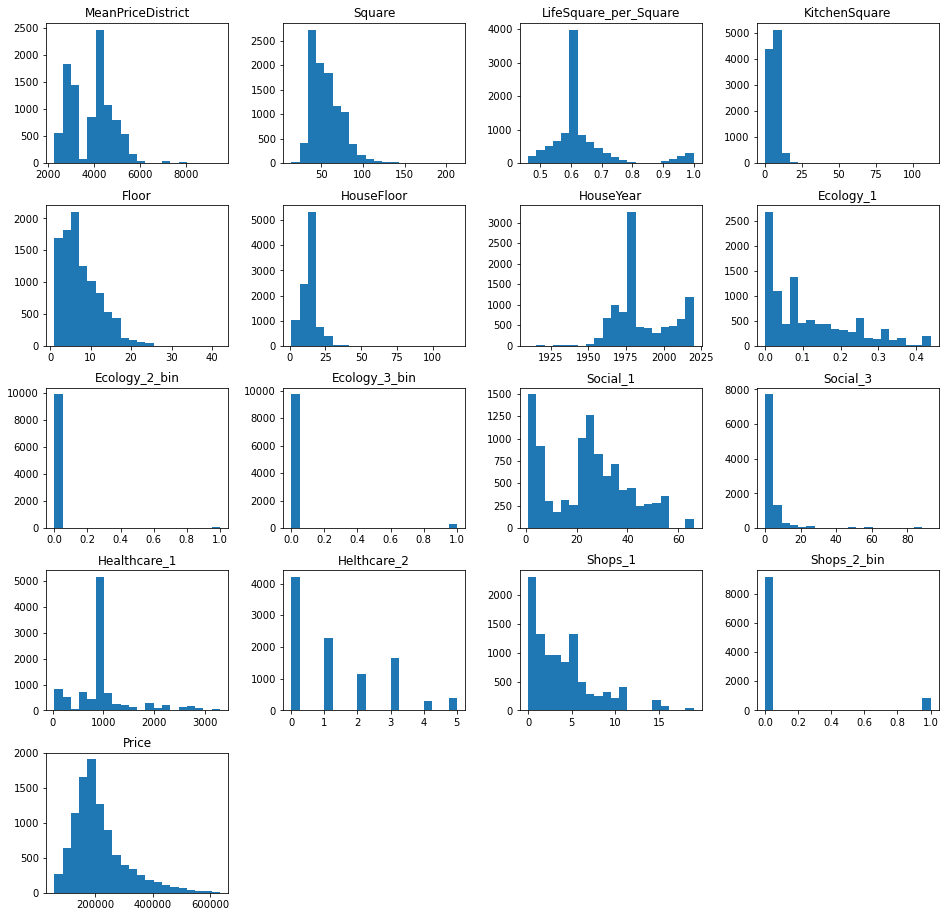

In [5]:
df.hist(figsize=(16,16), bins=20, grid=False)
plt.show()

Посмотрим количество выбросов в площади, площади кухни и этажности дома

In [6]:
len(df[(df['KitchenSquare'] > 17) | (df['HouseFloor'] > 50) | (df['Square'] > 150)].index)

75

Удалим строки по вышестоящему условию

In [7]:
df = df[~((df['KitchenSquare'] > 17) | (df['HouseFloor'] > 50) | (df['Square'] > 150))]
len(df.index)

9921

Теперь исправим выброс у LifeSquare_per_Square

In [8]:
df.loc[df['LifeSquare_per_Square'] > 0.85, 'LifeSquare_per_Square'] = df['LifeSquare_per_Square'].median()

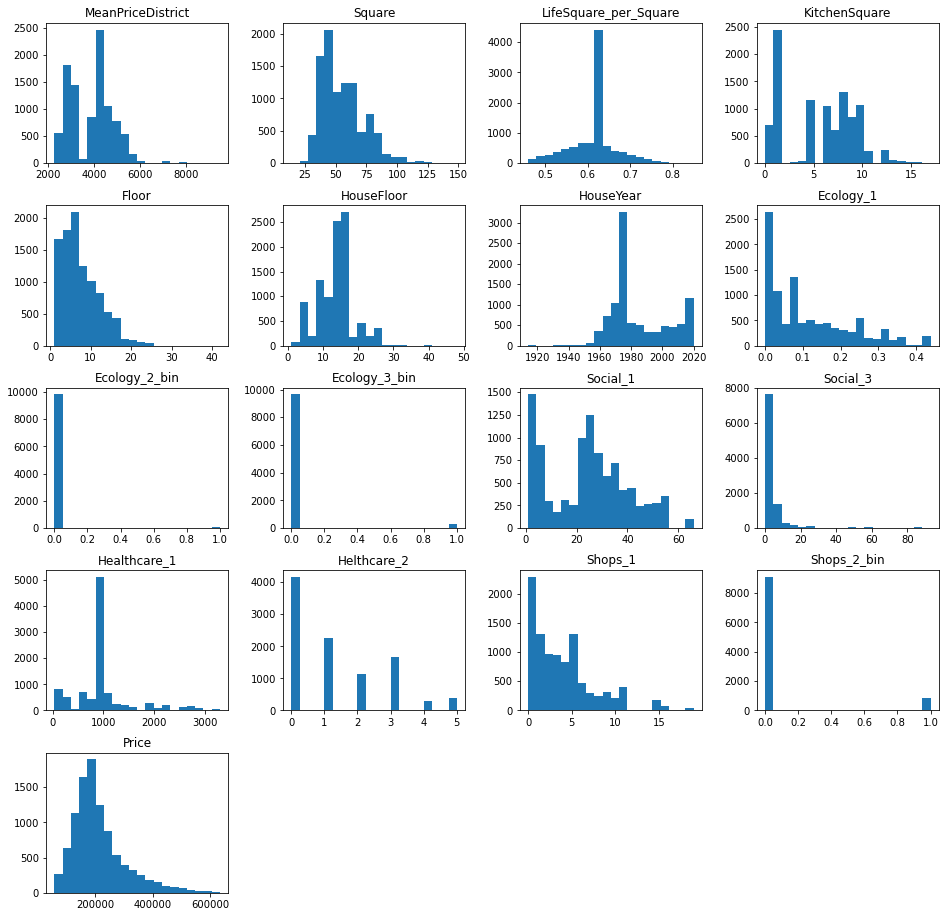

In [9]:
df.hist(figsize=(16,16), bins=20, grid=False)
plt.show()

Исправим выброс слева у площади кухни. Присвоим 0 все площади кухонь, меньших 2.5

In [10]:
df.loc[df['KitchenSquare'] < 2.5, 'KitchenSquare'] = df['KitchenSquare'].median()

Уменьшим объем памяти датасета

In [11]:
df['HouseFloor'] = df['HouseFloor'].astype(np.int64)

In [12]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [13]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 1.36 MB
Memory usage after optimization is: 0.44 MB
Decreased by 67.4%


### Построение моделей предсказания недвижимости
Получим наборы признаков и целевой переменной

In [14]:
target = 'Price'
y = df[target]
X = df.drop(target, axis=1)

Стандартизируем данные

In [15]:
scaler = StandardScaler()

cols = X.columns
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=cols)
X_scaled.describe()

,MeanPriceDistrict,Square,LifeSquare_per_Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_bin,Ecology_3_bin,Social_1,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2_bin
count,9.921000e+03,9.921000e+03,9.921000e+03,9921.000000,9.921000e+03,9921.000000,9921.000000,9.921000e+03,9921.000000,9921.000000,9921.000000,9921.000000,9.921000e+03,9921.000000,9921.000000,9921.000000
mean,-7.671642e-07,1.282692e-08,8.179672e-07,-0.000003,-9.437672e-07,0.000001,0.000002,7.569988e-09,0.000001,-0.000001,-0.000004,0.000006,9.257209e-07,-0.000006,-0.000006,0.000004
std,1.000046e+00,1.000049e+00,1.000048e+00,1.000084,1.000039e+00,1.000044,1.000041,1.000046e+00,1.000030,1.000066,1.000044,1.000050,1.000055e+00,1.000051,1.000043,1.000094
min,-1.702705e+00,-2.343392e+00,-2.716838e+00,-2.080277,-1.491564e+00,-2.484909,-3.864813,-1.024259e+00,-0.099367,-0.167897,-1.469302,-0.416555,-1.617280e+00,-0.896594,-0.990981,-0.299568
25%,-9.226900e-01,-7.832054e-01,-3.954512e-01,-0.625603,-8.458417e-01,-0.546264,-0.586823,-8.637799e-01,-0.099367,-0.167897,-0.965989,-0.416555,-2.187711e-01,-0.896594,-0.726565,-0.299568
50%,2.012653e-01,-1.916133e-01,8.658663e-02,-0.625603,-2.001191e-01,-0.158535,-0.422924,-3.383701e-01,-0.099367,-0.167897,0.040636,-0.237035,-9.640158e-02,-0.191361,-0.197732,-0.299568
75%,6.299494e-01,5.552309e-01,2.129569e-01,0.829071,6.608444e-01,0.616923,0.833639,6.925052e-01,-0.099367,-0.167897,0.669777,-0.057515,-9.640158e-02,0.513873,0.331100,-0.299568
max,5.877835e+00,5.183609e+00,4.230923e+00,4.708202,7.333311e+00,6.626724,1.926302,2.957787e+00,10.063714,5.956028,2.620114,7.931137,4.099125e+00,2.629574,4.032927,3.338144


Разобьем выборку на тренировочную и тестовую

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=100)

Обучим модель

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_pred_train = lr.predict(X_train)

In [18]:
r2_score(y_test, y_pred)

0.699331098928442

In [19]:
r2_score(y_train, y_pred_train)

0.6929480782739001

Результаты не очень хорошие, хотя модель не переобучена. Посмотрим распределение коэффициентов на графике

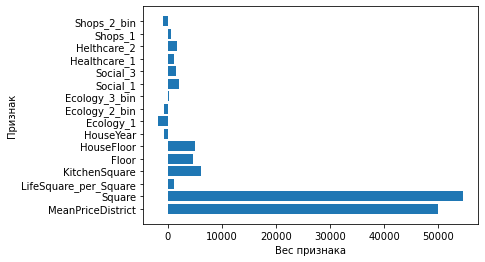

In [20]:
plt.barh(cols, lr.coef_.flatten())

plt.xlabel("Вес признака")
plt.ylabel("Признак")

plt.show()

Попробуем удалить два столбца с самыми маленькими коэффициентами ЛР - Shops_1 и Ecology_3_bin, и обучить модель еще раз

In [21]:
X_train.drop(['Shops_1', 'Ecology_3_bin'], axis=1, inplace=True)
X_test.drop(['Shops_1', 'Ecology_3_bin'], axis=1, inplace=True)

In [22]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
r2_score(y_test, y_pred)

0.6994486596555846

In [23]:
y_pred_train = lr.predict(X_train)
r2_score(y_train, y_pred_train)

0.6929112438243902

Как видно, качество модели немного улучшилось. Удаление других столбцов с самыми маленькими коэффициентами не дало увеличения параметра r2.

Посмотрим диаграмму рассеяния тестовой и предсказанной переменной

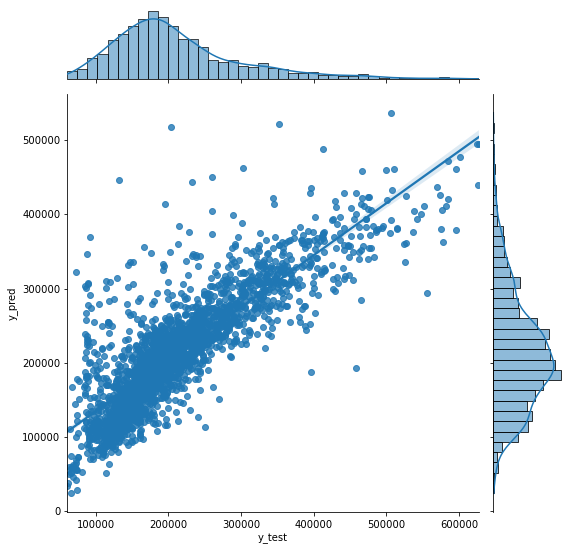

In [24]:
check_test = pd.DataFrame({
    "y_test": y_test,
    "y_pred": y_pred.flatten(),
})
grid = sns.jointplot(check_test["y_test"], check_test["y_pred"], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

Рассеяние некоторой части предсказанного признака довольно большое, но основная часть предсказаний неплохо коррелируется с тестовым целевым признаком

Попробуем теперь сделать предсказание с помощью случайного леса

In [25]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'n_estimators': [100, 150, 200],
    'max_features': np.arange(3, 12),
    'max_depth': np.arange(5, 15),
}

rfr = GridSearchCV(
    estimator=RandomForestRegressor(random_state=100),
    param_grid=parameters,
    scoring='r2',
    cv=4,
)

Произвел поиск оптимальных параметров:
```
rfr.fit(X_train, y_train)

rfr.best_params_
```
Ответ: 
```
{'max_depth': 12, 'max_features': 6, 'n_estimators': 150}
```
Пишу в маркдауне, чтоб при случайном запуске ячейки не зависнуть на полчаса.

In [26]:
rfr = RandomForestRegressor(max_depth=12, max_features=6, n_estimators=150, random_state=100)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
y_pred_train = rfr.predict(X_train)

In [27]:
r2_score(y_test, y_pred)

0.7686736233558477

In [28]:
r2_score(y_train, y_pred_train)

0.9216931423196939

Качество такой модели намного выше, чем линейной регрессии, хотя модель довольно сильно переобучена.

Посмотрим также диаграмму рассеяния тестовой и предсказанной переменной

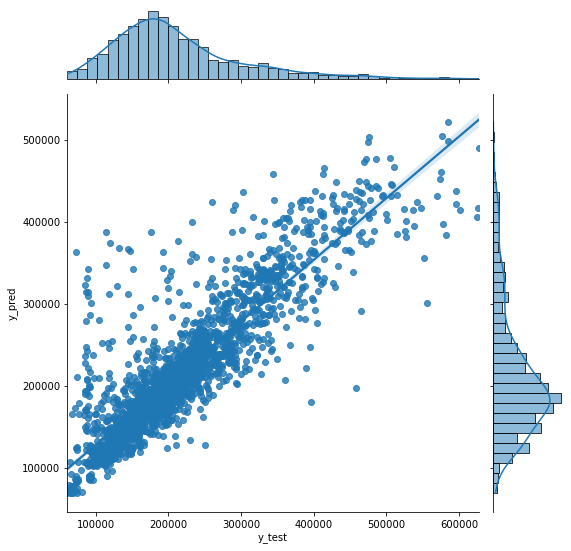

In [29]:
check_test = pd.DataFrame({
    "y_test": y_test,
    "y_pred": y_pred.flatten(),
})
grid = sns.jointplot(check_test["y_test"], check_test["y_pred"], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

Даже визуально видно, что разброс значений у этой модели намного ниже.

#### Общий вывод
Модель линейной регрессии хорошо подходит для таких датасетов, в которых признаки хорошо кореллируют с целевой переменной. В нашем случае было очень мало признаков, которые коррелировали с ценой квартиры. Соответственно, остальные признаки если и имели взаимосвязь с целевой переменной, то она была нелинейной. Соответственно, для таких моделей надо использовать модели, отличные от линейной регрессии